In [1]:
import numpy as np
import pandas as pd
import json
import nltk
nltk.download("stopwords") # add downloader for stopwords
nltk.download("wordnet") # add downloader for wordnet
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
tf.compat.v1.reset_default_graph()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aguga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aguga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
with open("reviewSelected100.json", 'r') as read_file:
    data = [json.loads(line) for line in read_file]

In [3]:
#Store all reviews in a Pandas DataFrame 
reviews = []
for rev in range(len(data)):
    reviews.append(data[rev]['text'])
    
rev_df = pd.DataFrame(reviews, columns = ['Reviews'])
rev_df.head()

,Reviews
0,We had my Mother's Birthday Party here on 10/2...
1,Good Korean grill near Eaton Centre. The marin...
2,Was recommended to try this place by few peopl...
3,Ambience: Would not expect something this nice...
4,Absolutely the WORST pool company that I have ...


In [4]:
#Clean data 
import re

#1. Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#2. Removes HTML syntaxesn(if reviews provide business links)
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#3. Removes URL data (if reviews provide business links)
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#4. Removes Emojis (if reviews contains expressions)
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#5. Lemmatize
def lemma_train(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_punctuations(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_html(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_url(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_emoji(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: lemma_train(z))

In [5]:
rev_df_clean = rev_df
rev_df_clean.head()

,Reviews
0,We had my Mothers Birthday Party here on 10291...
1,Good Korean grill near Eaton Centre The marina...
2,Was recommended to try this place by few peopl...
3,Ambience Would not expect something this nice ...
4,Absolutely the WORST pool company that I have ...


In [6]:
#Feature Engineering 

'''
Separate the reviews into positive and negative using nltk sentiment vader
'''
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_sent = SentimentIntensityAnalyzer()

rev_df_clean['ratings'] = rev_df_clean["Reviews"].apply(lambda x: nltk_sent.polarity_scores(x))
rev_df_new = pd.concat([rev_df_clean.drop(['ratings'], axis=1), rev_df_clean['ratings'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aguga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
rev_df_new['comp_rating'] = rev_df_new['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

rev_df_new.head()

,Reviews,neg,neu,pos,compound,comp_rating
0,We had my Mothers Birthday Party here on 10291...,0.000,0.592,0.408,0.9300,pos
1,Good Korean grill near Eaton Centre The marina...,0.055,0.736,0.208,0.9448,pos
2,Was recommended to try this place by few peopl...,0.006,0.687,0.307,0.9975,pos
3,Ambience Would not expect something this nice ...,0.094,0.759,0.148,0.8318,pos
4,Absolutely the WORST pool company that I have ...,0.090,0.885,0.026,-0.9402,neg


In [8]:
upd_df = rev_df_new.drop(columns=['neg','neu','pos','compound'])

In [9]:
sentiment_label = upd_df["comp_rating"].factorize()
sentiment_label

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 Index(['pos', 'neg'], dtype='object'))

In [11]:
text_data = upd_df["Reviews"]
from keras.preprocessing.text import Tokenizer

#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
encoded_text_data = tokenizer.texts_to_sequences(text_data)

In [12]:
SEQUENCE_LENGTH = 200
EMBEDDING_SIZE = 32
TEST_SIZE = 0.25
BATCH_SIZE = 32
EPOCHS = 5

In [13]:
#ensure all sentences are same size 
padded_text_data = pad_sequences(encoded_text_data, maxlen=200)


In [14]:
from tensorflow.keras.layers import Embedding,SpatialDropout1D

In [19]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1,
          EMBEDDING_SIZE,
          input_length=SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss='binary_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 32)           1140800   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 1,157,451
Trainable params: 1,157,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(padded_text_data,sentiment_label[0],validation_split=0.2,epochs=EPOCHS,batch_size=BATCH_SIZE)

Epoch 1/5
383/383 [==============================] - 68s 171ms/step - loss: 0.3753 - accuracy: 0.8547 - val_loss: 0.2949 - val_accuracy: 0.8742
Epoch 2/5
383/383 [==============================] - 73s 191ms/step - loss: 0.2343 - accuracy: 0.9037 - val_loss: 0.2881 - val_accuracy: 0.8794
Epoch 3/5
383/383 [==============================] - 70s 183ms/step - loss: 0.1797 - accuracy: 0.9280 - val_loss: 0.2828 - val_accuracy: 0.8788
Epoch 4/5
383/383 [==============================] - 66s 173ms/step - loss: 0.1443 - accuracy: 0.9451 - val_loss: 0.3903 - val_accuracy: 0.8961
Epoch 5/5
383/383 [==============================] - 65s 170ms/step - loss: 0.1128 - accuracy: 0.9572 - val_loss: 0.3202 - val_accuracy: 0.8915


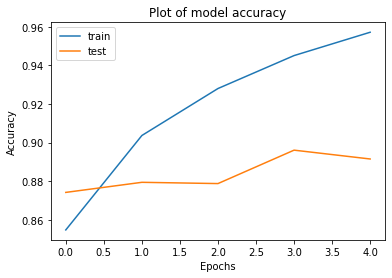

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.title("Plot of model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

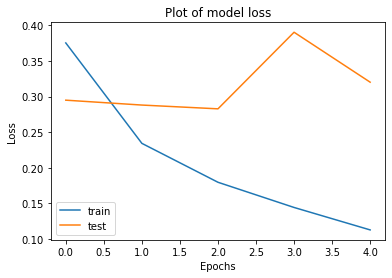

In [22]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.title("Plot of model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=200)
    # get the prediction
    prediction = int(model.predict(sequence).round().item())
    print("Predicted Label:", sentiment_label[1][prediction])


In [25]:
rev_text = "I ordered this chair last week. The condition was really good. The support is comfortable for the back and the seat is strong"

In [26]:
get_predictions(rev_text)

Predicted Label: pos


In [27]:
neg_rev = "Never again! The service was so slow and the food was not good."
get_predictions(neg_rev)

Predicted Label: pos


In [28]:
sample_df = upd_df["Reviews"].sample(n=20)
sample_df

14833    Purchase went fine They sold us a warranty say...
8721     I cant believe this has happened again to me a...
9122     In two years I have been there two times First...
12575    This pizza is great And Im really happy we hav...
2310     Very good barbeque  We had two combo plates  b...
12039    Cute little place to grab a quick bite to eat ...
10492    I really like this location My favourite is th...
4755     I agree with jj b These guys are like hawks ju...
10676    Came here for Summerlicious with 2 friends\nOr...
8900     Out of all the jack Astors that Ive been to th...
6347     Selfserve frozen yogurt place with various top...
8741     Crazy fun does not describe it hot people over...
2744     Horrible horrible beef I ordered two combo pla...
5363     Great service My tire was back ordered everywh...
8674     We go semiregularly  maybe every couple of mon...
12971    This was suppose to be such a good decision an...
10597    I was served dirty plates and the most awkward.

In [31]:
for text in sample_df:
    get_predictions(text)
    print(text)
    print("-----------")

Predicted Label: pos
Purchase went fine They sold us a warranty saying how great the service plan is and that we would go directly through them They sure sold us a load of crap You call and they have you call someone else Then its a game of pass the buck If you dont like what one does that have you call the other Spencers takes zero accountability for the warranty they sold We are just salesmen Yeah sales men who sold us garbage 4 weeks to fix a fridge is completely unacceptable Spencers says appliance repair should have overnighted parts Appliance repair says theres nothing they can do Warranty people say oh well we cant schedule till we have parts and those take 10 business days So a week for first appt 10 business days for parts another week wait after they get parts to get another repair appt Meanwhile we have a fridge that doesnt work BUYER BEWARE   Will never buy there again
-----------
Predicted Label: pos
I cant believe this has happened again to me and my son at this restauran

Predicted Label: neg
I was served dirty plates and the most awkward cup of green tea ever  a plastic cup full of large leaves with a bit of hot waterwhen I complainedof course no one spoke english This place sucks
-----------
Predicted Label: pos
Yummm I have been here before and it was okThis time omg the bahn mi is so goodthe bread toasted the veggies crunchy and freshI was quite hungry so this hit the spot seriouslyThey have premade noodle dishes and snacks in the front as wellCheapyummy food
-----------
Predicted Label: pos
This place is great  I came here on a Thursday to get a mani pedi before my wedding and they were able to see me right away and they did a great job   The pricing was a little high but the place is very clean so I didnt mind paying a little bit more  Also the aestheticians were very friendly  This place also has a ton of different colors and was able to recreate the picture that I had shown them indicating the look I was going for  They also offered water which 